<a href="https://colab.research.google.com/github/TayyabAhmed561/Hematology-Project/blob/main/Fixed_Bright_40x_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup and Imports**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For accurate error traceback

# Mount Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 🔧 Constants - Use input() to ask for paths
data_dir = "/content/drive/MyDrive/hematology_project/fixed_bright_40x"
label_path = "/content/drive/MyDrive/hematology_project/labels_cleaned.csv"
results_dir = "/content/drive/MyDrive/hematology_project/results"

os.makedirs(results_dir, exist_ok=True)

Mounted at /content/drive
Using device: cpu


# **Load Labels and Filter**

In [ ]:
import pandas as pd
from pathlib import Path # Keep this import as you might use Path elsewhere
import os

# Load the labels
labels_df = pd.read_csv(label_path)

# Set the correct image folder
# image_dir is already a string from your input()

# Ensure image_name contains only filenames (remove folder info if present)
labels_df['image_name'] = labels_df['image_name'].apply(os.path.basename)

# Filter out rows where the image file doesn't exist in the specified data_dir
labels_df = labels_df[labels_df['image_name'].apply(lambda x: os.path.exists(os.path.join(data_dir, x)))].reset_index(drop=True)

print("✅ Remaining images after filter (based on file existence):", len(labels_df))

# Extract patient ID from filename
labels_df['patient_id'] = labels_df['image_name'].apply(lambda x: os.path.basename(x).split('_')[0])

✅ Remaining images after filter (based on file existence): 278


# **Patient Wise Splitting**

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import GroupKFold
import torch # Import torch here if you need label_min_tensor/label_max_tensor in the loop

# Assuming labels_df, label_cols are defined from previous cells
# label_min_tensor and label_max_tensor are calculated per fold in the K-Fold loop

print("--- Starting Patient-Wise K-Fold Setup ---")

print(f"Total usable images after cleaning: {len(labels_df)}")
print(f"Unique patients: {labels_df['patient_id'].nunique()}")

if labels_df['patient_id'].nunique() == 0:
    raise ValueError("No valid patients found after cleaning — check your image filtering or filenames.")

# --- K-Fold Setup ---
N_SPLITS = 5  # You can choose the number of folds (e.g., 5 or 10)
print(f"\nSetting up {N_SPLITS}-Fold Cross-Validation with patient grouping...")

gkf = GroupKFold(n_splits=N_SPLITS)
print(f"Initialized GroupKFold with {N_SPLITS} splits.")

# Get the groups for splitting (patient IDs)
groups = labels_df['patient_id']
print(f"Using patient IDs as groups for splitting.")
# Optional: print a sample of the groups
# print("Sample patient groups:", groups.head())


# Prepare lists to store metrics for each fold
fold_test_losses = []
# Add lists for other metrics you want to track per fold, e.g.:
fold_macro_aucs = []
# fold_confusion_matrices = {label: [] for label in label_cols} # Example for storing CMs per label

print("\nInitialized lists to store metrics for each fold.")

# The splitting and iteration will happen in the main training execution loop now
print("\nK-Fold splitting and iteration will occur in the next code block.")

print("--- Patient-Wise K-Fold Setup Complete ---")

--- Starting Patient-Wise K-Fold Setup ---
Total usable images after cleaning: 278
Unique patients: 30

Setting up 5-Fold Cross-Validation with patient grouping...
Initialized GroupKFold with 5 splits.
Using patient IDs as groups for splitting.

Initialized lists to store metrics for each fold.

K-Fold splitting and iteration will occur in the next code block.
--- Patient-Wise K-Fold Setup Complete ---


# **Custom Dataset**

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np

# actual_label_cols should be defined already from the Clean Labels section

class CBCDataset(Dataset):
    # Use the scaled dataframe
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe # This is now the scaled dataframe
        self.transform = transform
        self.label_cols = label_cols # Use the explicitly defined label columns
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        image_name = row['image_name']
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Labels are already scaled in the dataframe
        labels = row[self.label_cols].values.astype(np.float32)

        if np.isnan(labels).any():
             raise ValueError(f"[ERROR] Found NaN in scaled labels for index {idx}: {labels}")

        labels = torch.tensor(labels, dtype=torch.float32)

        # Sanity checks
        assert image.shape[0] == 3, f"Expected RGB image but got shape {image.shape}"
        assert labels.ndim == 1, f"Labels should be 1D, got shape {labels.shape}"
        assert labels.dtype == torch.float32, f"Labels dtype should be float32 but got {labels.dtype}"
        assert labels.shape[0] == len(self.label_cols), f"Label tensor shape {labels.shape} does not match expected number of labels {len(self.label_cols)}"
        # Check if scaled labels are within the expected range [0, 1]
        # These assertions might be too strict due to floating point, but are good for debugging
        # assert torch.all(labels >= 0) and torch.all(labels <= 1), f"Scaled labels out of [0, 1] range for index {idx}: {labels}"


        return image, labels

# **Clean Labels**

In [ ]:
import pandas as pd
import numpy as np # Import numpy

# Load your DataFrame (replace with your actual loading logic)
# labels_df = pd.read_csv(label_path) # Use labels_df from the previous section

# Columns to exclude (make sure this is consistent)
columns_to_exclude = ['image_name', 'live', 'magnification', 'brightfield', 'patient_id']

# Step 1: Identify the label columns
label_cols = [col for col in labels_df.columns if col not in columns_to_exclude]

print("Label columns identified for scaling:", label_cols)

# Step 2: Convert label columns to numeric and handle invalid entries
for col in label_cols:
    labels_df[col] = pd.to_numeric(labels_df[col], errors='coerce')

# Find rows with NaN in any of the label columns (for reporting)
rows_with_nan = labels_df[labels_df[label_cols].isna().any(axis=1)]
if not rows_with_nan.empty:
    print("Rows with NaN in label columns before dropping:")
    print(rows_with_nan)

# Step 3: Drop any rows with NaNs in the labels
initial_len = len(labels_df)
labels_df = labels_df.dropna(subset=label_cols).reset_index(drop=True)
if len(labels_df) < initial_len:
    print(f"Dropped {initial_len - len(labels_df)} rows with NaNs.")

# Step 4: Remove all-zero label rows
initial_len = len(labels_df)
labels_df = labels_df[~(labels_df[label_cols].sum(axis=1) == 0)].reset_index(drop=True)
if len(labels_df) < initial_len:
     print(f"Dropped {initial_len - len(labels_df)} all-zero label rows.")

# Step 5: Remove all-one label rows (This might not be relevant for continuous CBC parameters,
# but keep it if your labels could potentially be all 1s)
# initial_len = len(labels_df)
# labels_df = labels_df[~(labels_df[label_cols].sum(axis=1) == len(label_cols))].reset_index(drop=True)
# if len(labels_df) < initial_len:
#      print(f"Dropped {initial_len - len(labels_df)} all-one label rows.")

print("Remaining samples after cleaning:", len(labels_df))


# --- Label Scaling (Min-Max Example) ---
# Calculate min and max from the training data AFTER the split
# (This requires the split to happen *before* scaling)

# Move the splitting code from "Patient Wise Splitting" here:
import os
from sklearn.model_selection import train_test_split

# Extract patient_id (prefix before underscore)
labels_df['patient_id'] = labels_df['image_name'].apply(lambda x: x.split('_')[0])

# Double-check:
print(f"Total usable images after cleaning: {len(labels_df)}")
print(f"Unique patients: {labels_df['patient_id'].nunique()}")

# Proceed only if there are patients to split
if labels_df['patient_id'].nunique() == 0:
    raise ValueError("No valid patients found after cleaning — check your image filtering or filenames.")

# Patient-wise splitting
unique_patients = labels_df['patient_id'].unique()

# Split: 70% train, 30% temp (to be split into val/test)
train_ids, temp_ids = train_test_split(unique_patients, test_size=0.3, random_state=42)

# Split the 30% temp into 2/3 test (i.e., 20% total) and 1/3 val (10% total)
test_ids, val_ids = train_test_split(temp_ids, test_size=1/3, random_state=42)

def get_split(df, split_ids):
    return df[df['patient_id'].isin(split_ids)].reset_index(drop=True)

train_df = get_split(labels_df, train_ids)
val_df = get_split(labels_df, val_ids)
test_df = get_split(labels_df, test_ids)

# --- Calculate Scaling Parameters from Training Data ---
label_min = train_df[label_cols].min().values
label_max = train_df[label_cols].max().values

# Store these for inverse scaling later
label_min_tensor = torch.tensor(label_min, dtype=torch.float32)
label_max_tensor = torch.tensor(label_max, dtype=torch.float32)

# --- Apply Scaling to all splits ---
def scale_labels(df, label_cols, min_vals, max_vals):
    scaled_df = df.copy()
    # Avoid division by zero if min == max for a column
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1 # Handle cases where a label is constant
    scaled_df[label_cols] = (df[label_cols] - min_vals) / range_vals
    # Clip to [0, 1] to handle potential floating point inaccuracies
    scaled_df[label_cols] = scaled_df[label_cols].clip(lower=0, upper=1)
    return scaled_df

train_df_scaled = scale_labels(train_df, label_cols, label_min, label_max)
val_df_scaled = scale_labels(val_df, label_cols, label_min, label_max)
test_df_scaled = scale_labels(test_df, label_cols, label_min, label_max)

print("\nScaled Train DataFrame sample:")
print(train_df_scaled[label_cols].head())
print("\nScaled Val DataFrame sample:")
print(val_df_scaled[label_cols].head())
print("\nScaled Test DataFrame sample:")
print(test_df_scaled[label_cols].head())

Label columns identified for scaling: ['basophil', 'neutrophil', 'RDW', 'RBC', 'platelet', 'monocyte', 'MCV', 'MCHC', 'lymphocyte', 'hemoglobin', 'hematocrit', 'eosinophil', 'WBC', 'MCH']
Remaining samples after cleaning: 278
Total usable images after cleaning: 278
Unique patients: 30

Scaled Train DataFrame sample:
   basophil  neutrophil       RDW       RBC  platelet  monocyte       MCV  \
0       0.5    0.113636  0.424242  0.188073  0.272206  0.222222  0.789474   
1       0.5    0.113636  0.424242  0.188073  0.272206  0.222222  0.789474   
2       0.5    0.113636  0.424242  0.188073  0.272206  0.222222  0.789474   
3       0.5    0.113636  0.424242  0.188073  0.272206  0.222222  0.789474   
4       0.5    0.113636  0.424242  0.188073  0.272206  0.222222  0.789474   

   MCHC  lymphocyte  hemoglobin  hematocrit  eosinophil       WBC   MCH  
0   0.0    0.521739    0.204545         0.3    0.333333  0.196721  0.75  
1   0.0    0.521739    0.204545         0.3    0.333333  0.196721  0.75

# **Transforms and Loaders**

In [ ]:
# Define transforms for training with augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Example augmentation
    transforms.RandomHorizontalFlip(), # Example augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Example augmentation
    transforms.RandomRotation(15), # Example augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transforms for validation and testing (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Use the scaled dataframes and apply appropriate transforms
train_loader = DataLoader(CBCDataset(train_df_scaled, data_dir, transform=train_transform), batch_size=32, shuffle=True)
val_loader = DataLoader(CBCDataset(val_df_scaled, data_dir, transform=val_test_transform), batch_size=32)
test_loader = DataLoader(CBCDataset(test_df_scaled, data_dir, transform=val_test_transform), batch_size=32)

# **verification**

In [ ]:
# --- Verification Cell: Confirming Training Dataset Size and Image Existence ---

print("--- Verification Checks ---")

# 1. Check the size of train_df_scaled
print("Number of images in train_df_scaled:", len(train_df_scaled))

# 2. Check the length of the train_loader dataset
print("Length of train_loader dataset:", len(train_loader.dataset))

print("Length of val_loader dataset:", len(val_loader.dataset))

# 3. Verify images exist for rows in train_df_scaled
print("\nChecking existence of training images in data directory...")
missing_train_images = []
for image_name in train_df_scaled['image_name']:
    image_path = os.path.join(data_dir, image_name)
    if not os.path.exists(image_path):
        missing_train_images.append(image_name)

if missing_train_images:
    print("Warning: The following images listed in train_df_scaled are missing:")
    for img in missing_train_images:
        print(img)
else:
    print("All images in train_df_scaled exist in the data directory.")

# 4. Review the patient-wise split (Assuming labels_df is available from earlier cells)
if 'labels_df' in locals():
    print("\nReviewing images belonging to patients in the train split...")
    images_in_train_patients = labels_df[labels_df['patient_id'].isin(train_ids)]
    print("Number of images belonging to patients in the train split (from original labels_df):", len(images_in_train_patients))
else:
    print("\nCould not perform patient split check: labels_df is not available.")

print("--- Verification Checks Complete ---")

--- Verification Checks ---
Number of images in train_df_scaled: 200
Length of train_loader dataset: 200
Length of val_loader dataset: 25

Checking existence of training images in data directory...
All images in train_df_scaled exist in the data directory.

Reviewing images belonging to patients in the train split...
Number of images belonging to patients in the train split (from original labels_df): 200
--- Verification Checks Complete ---


# **Model Setup**

In [ ]:
def get_resnet18_regression(n_outputs):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # Freeze backbone parameters
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, n_outputs)  # No Sigmoid
    )
    return model.to(device)

# ✅ Correctly set n_labels to the number of label columns
n_labels = len(label_cols)
model = get_resnet18_regression(n_labels)

# Add weight_decay for L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # Start with a small value like 1e-5

# ✅ Regression loss
criterion = nn.MSELoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


# **Training Loop**

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        targets = targets.float()
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

# **Evaluation**

In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_outputs, all_targets = [], []

    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * imgs.size(0)
        all_outputs.append(outputs.cpu())
        all_targets.append(targets.cpu())

    outputs = torch.cat(all_outputs)
    targets = torch.cat(all_targets)

    print(f"[DEBUG] Total loss accumulated: {total_loss}")
    print(f"[DEBUG] Dataset size: {len(loader.dataset)}")

    return total_loss / len(loader.dataset), outputs.numpy(), targets.numpy()


# **Print Min/Max Values**

In [ ]:
# After the "Clean Labels" cell, but before the K-Fold setup

print("--- True Range of CBC Parameters (Original Scale) ---")
for label in label_cols:
    min_val = labels_df[label].min()
    max_val = labels_df[label].max()
    print(f"{label}: Min = {min_val:.2f}, Max = {max_val:.2f}")
print("--- End True Range ---")


--- True Range of CBC Parameters (Original Scale) ---
basophil: Min = 0.00, Max = 0.20
neutrophil: Min = 2.10, Max = 11.20
RDW: Min = 11.20, Max = 15.20
RBC: Min = 3.89, Max = 6.07
platelet: Min = 103.00, Max = 452.00
monocyte: Min = 0.20, Max = 2.70
MCV: Min = 66.00, Max = 104.00
MCHC: Min = 316.00, Max = 348.00
lymphocyte: Min = 0.50, Max = 3.50
hemoglobin: Min = 121.00, Max = 172.00
hematocrit: Min = 0.38, Max = 0.49
eosinophil: Min = 0.00, Max = 0.60
WBC: Min = 3.80, Max = 17.70
MCH: Min = 21.00, Max = 33.00
--- End True Range ---


# **Define Bin Edges**

In [ ]:
# Define bin_edges for visualization and evaluation
# These are initial or default bin edges. Dynamic binning will be used for CM calculation.
bin_edges = {
    'hematocrit': [0.38, 0.40, 0.42, 0.44, 0.46, 0.49],
    'WBC': [3.5, 6, 8, 10, 13, 17.7],
    'RBC': [3.8, 4.5, 5.0, 5.5, 6.1],
    'basophil': [0.00, 0.05, 0.10, 0.15, 0.20], # Suggested based on range
    'neutrophil': [2.0, 4.0, 6.0, 8.0, 10.0, 12.0], # Suggested based on range and typical clinical values
    'RDW': [11.0, 12.0, 13.0, 14.0, 15.0, 16.0], # Suggested based on range
    'platelet': [100, 150, 200, 250, 300, 350, 400, 450, 500], # Suggested based on range and typical clinical values
    'monocyte': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], # Suggested based on range and typical clinical values
    'MCV': [60, 70, 80, 90, 100, 110], # Suggested based on range and typical clinical values
    'MCHC': [310, 320, 330, 340, 350], # Suggested based on range and typical clinical values
    'lymphocyte': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], # Suggested based on range and typical clinical values
    'hemoglobin': [120, 130, 140, 150, 160, 170, 180], # Suggested based on range and typical clinical values
    'eosinophil': [0.00, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60], # Suggested based on range
    'MCH': [20, 24, 28, 32, 36], # Suggested based on range and typical clinical values
}

# Define selected labels for evaluation metrics (using label_cols from previous cell)
# Include all labels in label_cols that you want to evaluate
selected_labels = label_cols # Use all defined label columns for evaluation

# Get the indices of the selected labels within the label_cols list
# Ensure label_cols is defined from the Clean Labels section
label_indices = [label_cols.index(lab) for lab in selected_labels]

# Initialize dictionaries for storing metrics per fold
fold_test_losses = [] # Moved from Train Loop Execution
fold_macro_aucs = [] # Moved from Train Loop Execution
# Initialize fold_cms to store lists of CMs for each selected label
fold_cms = {label: [] for label in selected_labels}

# Define binary thresholds and initialize dictionary for binary CMs
# Define binary thresholds for selected labels (on original scale)
# These are suggested thresholds based on common clinical values.
binary_thresholds = {
    'hematocrit': 40,       # Example: Using 40 as a potential threshold for anemia (lower bound of normal)
    'WBC': 10,              # Example: Using 10 as a potential threshold for high WBC (upper bound of normal)
    'RBC': 4.0,             # Example: Using 4.0 as a potential threshold for low RBC (lower bound of normal for women, adjust as needed)
    'basophil': 0.01,       # Example: Using 0.01 as a low threshold (lower range of normal)
    'neutrophil': 2.5,      # Example: Using 2.5 as a low threshold (lower range of normal)
    'RDW': 14.5,            # Example: Using 14.5 as a high threshold (upper range of normal)
    'platelet': 150,        # Example: Using 150 as a low threshold (lower range of normal)
    'monocyte': 0.2,        # Example: Using 0.2 as a low threshold (lower range of normal)
    'MCV': 80,              # Example: Using 80 as a low threshold (lower range of normal)
    'MCHC': 320,            # Example: Using 320 as a low threshold (lower range of normal)
    'lymphocyte': 1.0,      # Example: Using 1.0 as a low threshold (lower range of normal)
    'hemoglobin': 120,      # Example: Using 120 as a low threshold (lower range of normal for women, adjust as needed)
    'eosinophil': 0.05,     # Example: Using 0.05 as a high threshold (upper range of normal can vary)
    'MCH': 27,              # Example: Using 27 as a low threshold (lower range of normal)
}
# Initialize fold_binary_cms to store lists of binary CMs for selected labels with defined thresholds
fold_binary_cms = {label: [] for label in selected_labels if label in binary_thresholds}


# Optional: Lists to store loss histories for plotting average curves (Moved from Train Loop Execution)
all_fold_train_losses = []
all_fold_val_losses = []

# Define patience (Moved from Train Loop Execution)
patience = 5

# **Drawing Histograms**


--- Histograms of CBC Parameters (Original Scale) ---


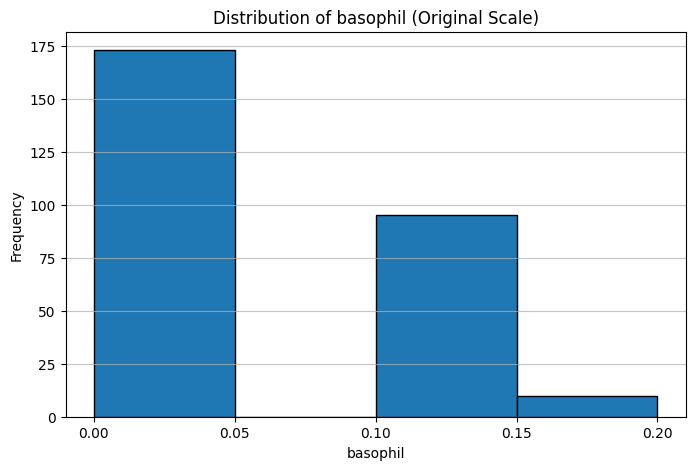

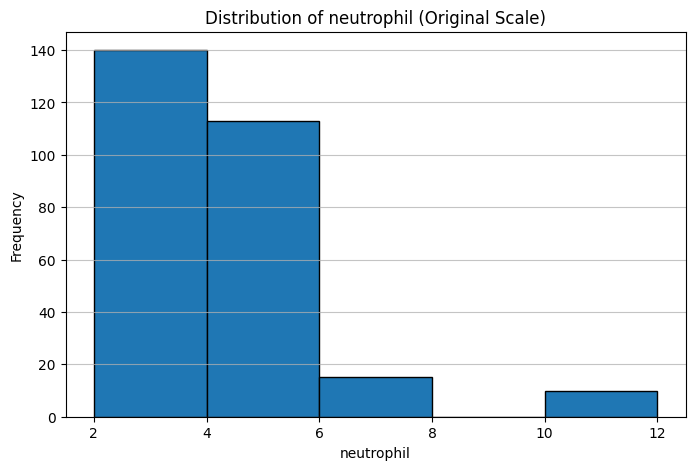

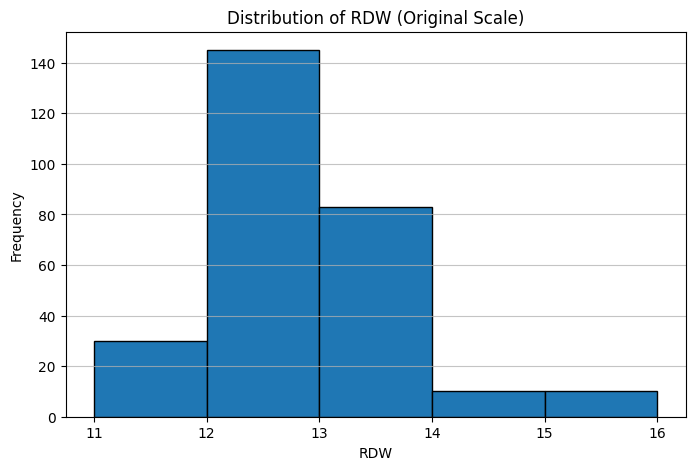

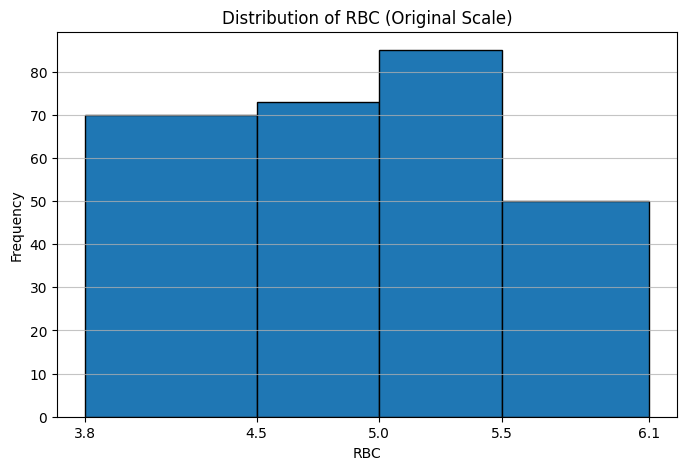

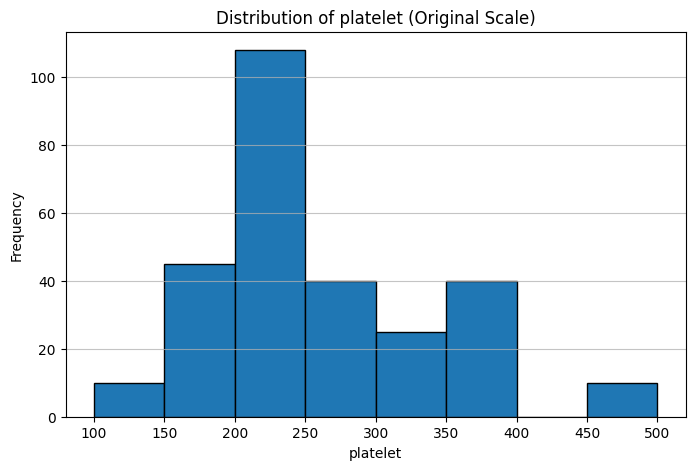

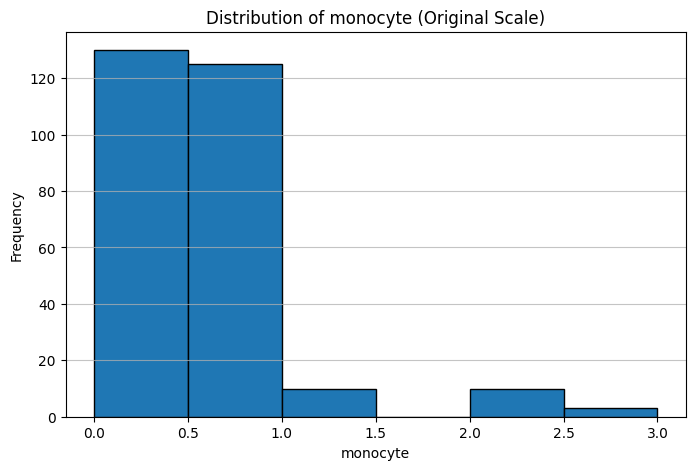

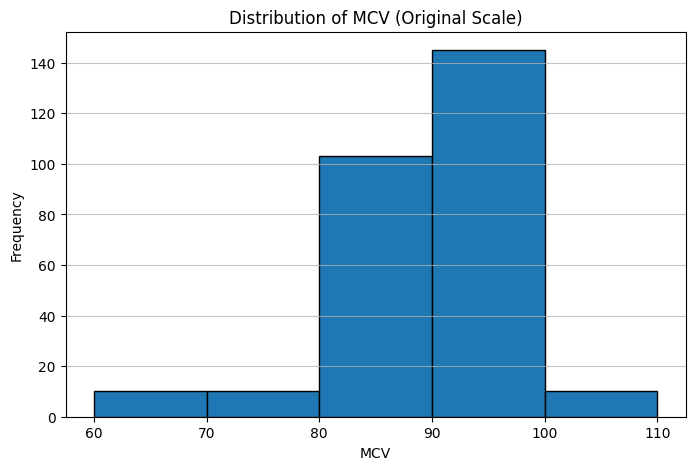

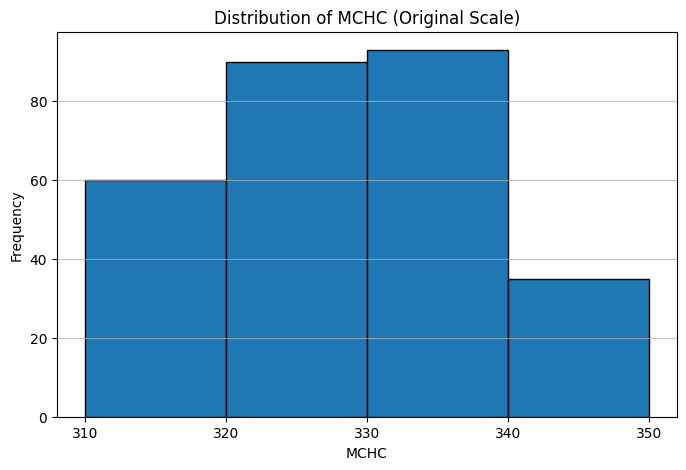

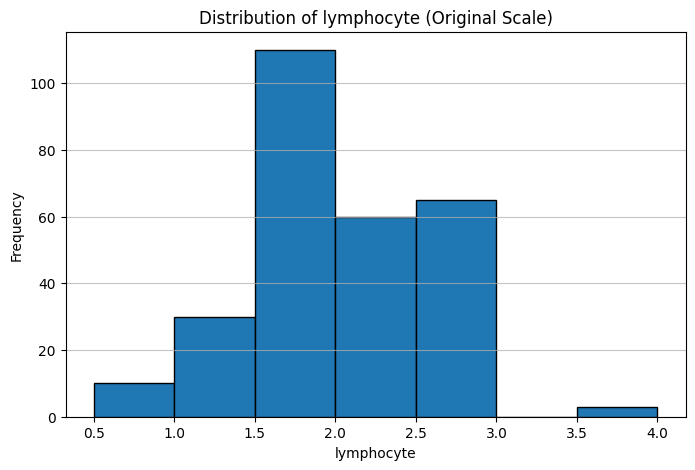

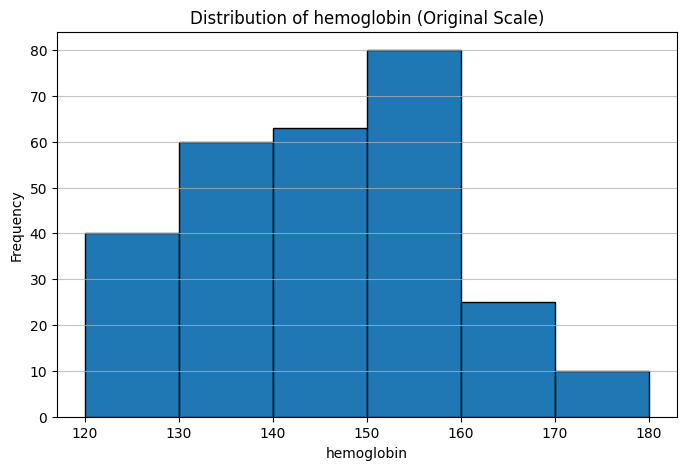

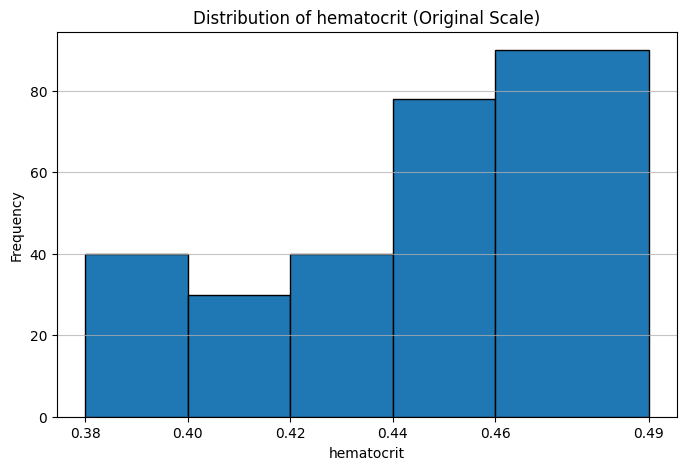

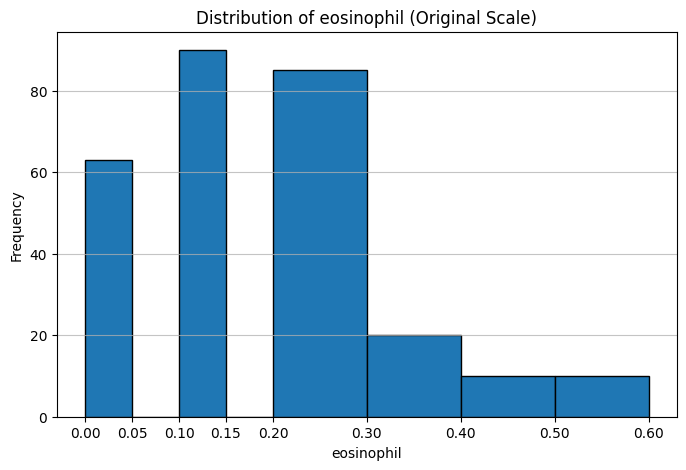

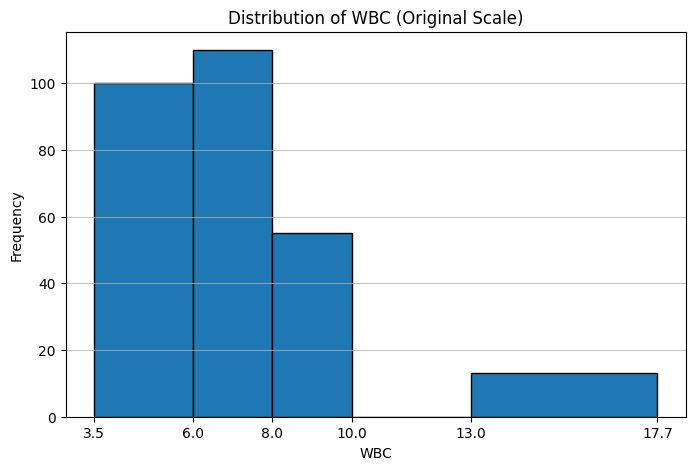

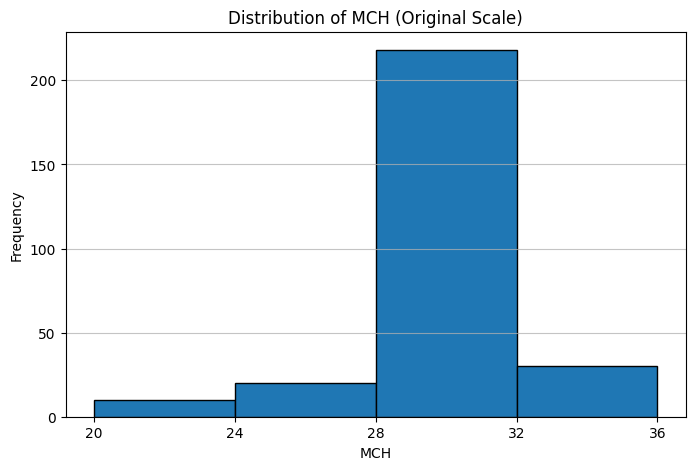

--- End Histograms ---


In [ ]:
# After the "Clean Labels" cell, but before the K-Fold setup

print("\n--- Histograms of CBC Parameters (Original Scale) ---")
for label in label_cols:
    plt.figure(figsize=(8, 5))
    # Use a reasonable number of bins or your predefined bin_edges if they make sense for visualization
    if label in bin_edges: # Use predefined bins if they exist and make sense for visualization
          plt.hist(labels_df[label], bins=bin_edges[label], edgecolor='black')
          plt.xticks(bin_edges[label]) # Set x-ticks at the bin edges
    else: # Use a default number of bins
          plt.hist(labels_df[label], bins=30, edgecolor='black') # Adjust bin count as needed
    plt.title(f"Distribution of {label} (Original Scale)")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()
print("--- End Histograms ---")

# **Train Loop Execution**

Starting K-Fold Cross-Validation...

--- Starting Fold 1/5 ---
Fold 1: Train patients: 20 (183 images)
Fold 1: Val patients: 4 (35 images)
Fold 1: Test patients: 6 (60 images)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Fold 1...
[DEBUG] Total loss accumulated: 4.537510126829147
[DEBUG] Dataset size: 35
  Fold 1, Epoch 1/50 | Train Loss: 0.3296 | Val Loss: 0.1296 | Duration: 144.89s
[DEBUG] Total loss accumulated: 2.766453094780445
[DEBUG] Dataset size: 35
  Fold 1, Epoch 2/50 | Train Loss: 0.2182 | Val Loss: 0.0790 | Duration: 42.73s
[DEBUG] Total loss accumulated: 2.2147206366062164
[DEBUG] Dataset size: 35
  Fold 1, Epoch 3/50 | Train Loss: 0.1718 | Val Loss: 0.0633 | Duration: 42.91s
[DEBUG] Total loss accumulated: 2.065534494817257
[DEBUG] Dataset size: 35
  Fold 1, Epoch 4/50 | Train Loss: 0.1577 | Val Loss: 0.0590 | Duration: 42.55s
[DEBUG] Total loss accumulated: 2.046036936342716
[DEBUG] Dataset size: 35
  Fold 1, Epoch 5/50 | Train Loss: 0.1353 | Val Loss: 0.0585 | Duration: 42.52s
[DEBUG] Total loss accumulated: 2.0878996402025223
[DEBUG] Dataset size: 35
  Fold 1, Epoch 6/50 | Train Loss: 0.1256 | Val Loss: 0.0597 | Duration: 44.57s
[DEBUG] Total loss accumulated: 2.07706145942211

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


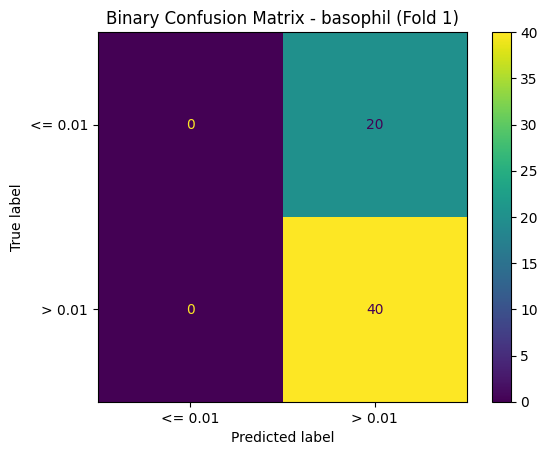

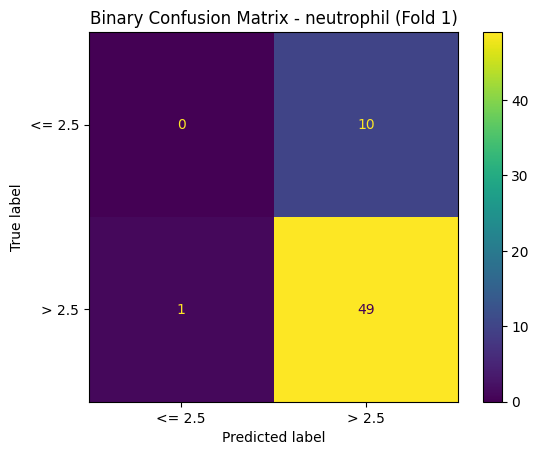

  Fold 1: Not enough class diversity for binary CM (RDW).


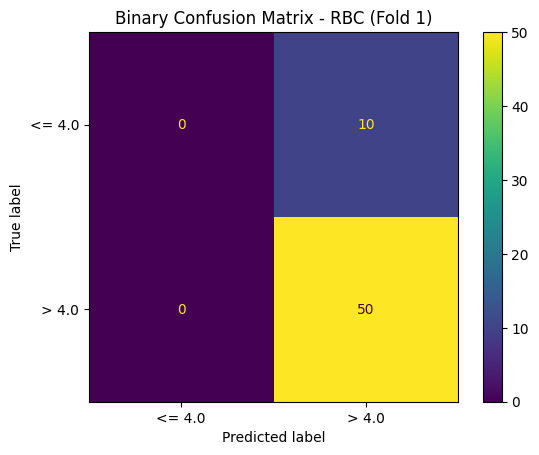

  Fold 1: Not enough class diversity for binary CM (platelet).
  Fold 1: Not enough class diversity for binary CM (monocyte).


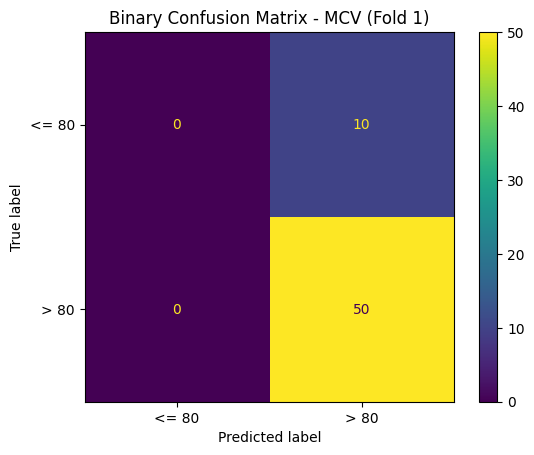

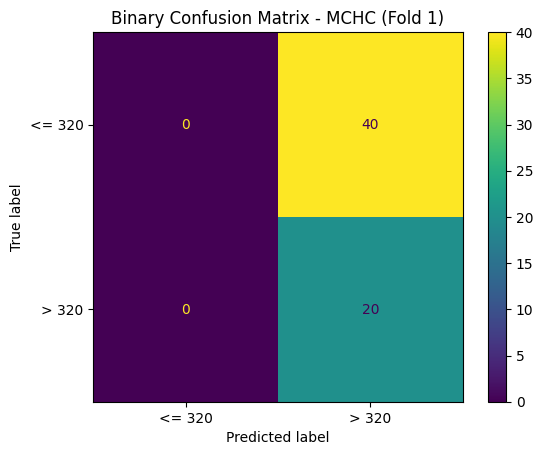

  Fold 1: Not enough class diversity for binary CM (lymphocyte).
  Fold 1: Not enough class diversity for binary CM (hemoglobin).
  Fold 1: Not enough class diversity for binary CM (hematocrit).


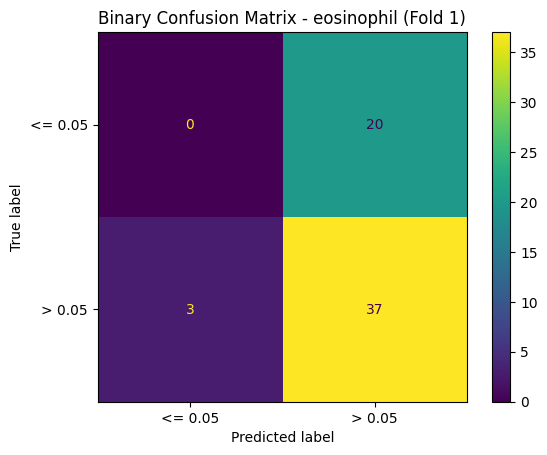

  Fold 1: Not enough class diversity for binary CM (WBC).


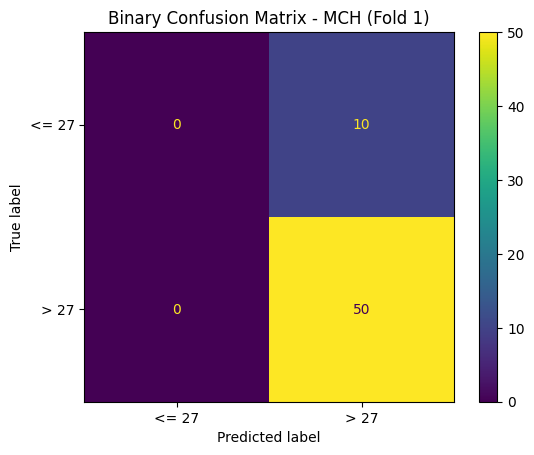


--- Starting Fold 2/5 ---
Fold 2: Train patients: 20 (183 images)
Fold 2: Val patients: 4 (40 images)
Fold 2: Test patients: 6 (55 images)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Fold 2...
[DEBUG] Total loss accumulated: 5.009632647037506
[DEBUG] Dataset size: 40
  Fold 2, Epoch 1/50 | Train Loss: 0.2778 | Val Loss: 0.1252 | Duration: 45.36s
[DEBUG] Total loss accumulated: 3.78527969121933
[DEBUG] Dataset size: 40
  Fold 2, Epoch 2/50 | Train Loss: 0.1959 | Val Loss: 0.0946 | Duration: 49.02s
[DEBUG] Total loss accumulated: 3.085483729839325
[DEBUG] Dataset size: 40
  Fold 2, Epoch 3/50 | Train Loss: 0.1605 | Val Loss: 0.0771 | Duration: 44.79s
[DEBUG] Total loss accumulated: 2.8667545914649963
[DEBUG] Dataset size: 40
  Fold 2, Epoch 4/50 | Train Loss: 0.1495 | Val Loss: 0.0717 | Duration: 44.91s
[DEBUG] Total loss accumulated: 2.8099659383296967
[DEBUG] Dataset size: 40
  Fold 2, Epoch 5/50 | Train Loss: 0.1333 | Val Loss: 0.0702 | Duration: 44.15s
[DEBUG] Total loss accumulated: 2.720522880554199
[DEBUG] Dataset size: 40
  Fold 2, Epoch 6/50 | Train Loss: 0.1354 | Val Loss: 0.0680 | Duration: 44.15s
[DEBUG] Total loss accumulated: 2.6765493750572205

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


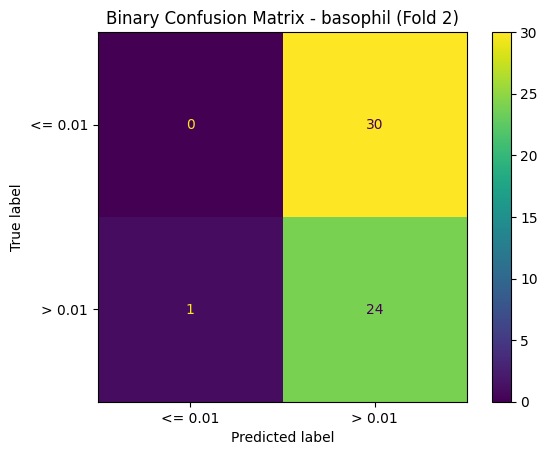

  Fold 2: Not enough class diversity for binary CM (neutrophil).
  Fold 2: Not enough class diversity for binary CM (RDW).
  Fold 2: Not enough class diversity for binary CM (RBC).
  Fold 2: Not enough class diversity for binary CM (platelet).
  Fold 2: Not enough class diversity for binary CM (monocyte).
  Fold 2: Not enough class diversity for binary CM (MCV).
  Fold 2: Not enough class diversity for binary CM (MCHC).
  Fold 2: Not enough class diversity for binary CM (lymphocyte).
  Fold 2: Not enough class diversity for binary CM (hemoglobin).
  Fold 2: Not enough class diversity for binary CM (hematocrit).


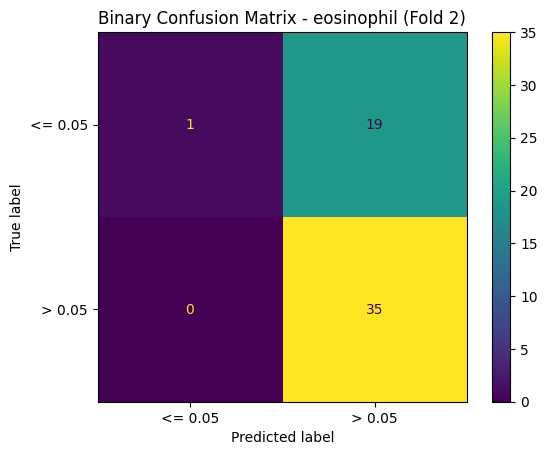

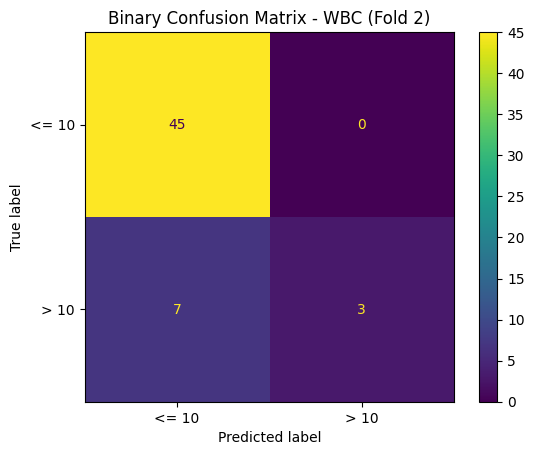

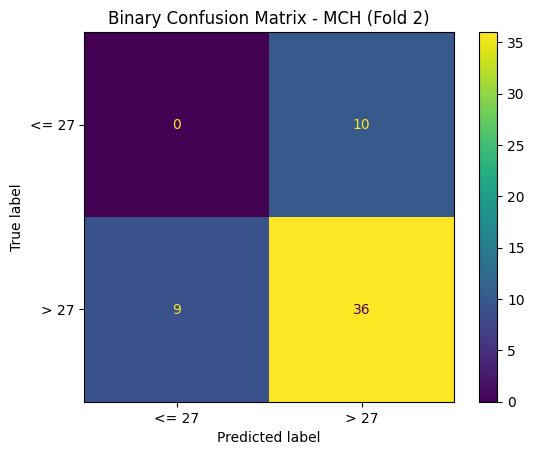


--- Starting Fold 3/5 ---
Fold 3: Train patients: 20 (183 images)
Fold 3: Val patients: 4 (40 images)
Fold 3: Test patients: 6 (55 images)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Fold 3...
[DEBUG] Total loss accumulated: 9.71664547920227
[DEBUG] Dataset size: 40
  Fold 3, Epoch 1/50 | Train Loss: 0.4231 | Val Loss: 0.2429 | Duration: 43.29s
[DEBUG] Total loss accumulated: 6.530617594718933
[DEBUG] Dataset size: 40
  Fold 3, Epoch 2/50 | Train Loss: 0.2662 | Val Loss: 0.1633 | Duration: 43.72s
[DEBUG] Total loss accumulated: 4.851517975330353
[DEBUG] Dataset size: 40
  Fold 3, Epoch 3/50 | Train Loss: 0.1834 | Val Loss: 0.1213 | Duration: 43.58s
[DEBUG] Total loss accumulated: 4.118441581726074
[DEBUG] Dataset size: 40
  Fold 3, Epoch 4/50 | Train Loss: 0.1630 | Val Loss: 0.1030 | Duration: 43.50s
[DEBUG] Total loss accumulated: 3.668131947517395
[DEBUG] Dataset size: 40
  Fold 3, Epoch 5/50 | Train Loss: 0.1508 | Val Loss: 0.0917 | Duration: 48.47s
[DEBUG] Total loss accumulated: 3.386021703481674
[DEBUG] Dataset size: 40
  Fold 3, Epoch 6/50 | Train Loss: 0.1437 | Val Loss: 0.0847 | Duration: 44.06s
[DEBUG] Total loss accumulated: 3.2691018879413605
[

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


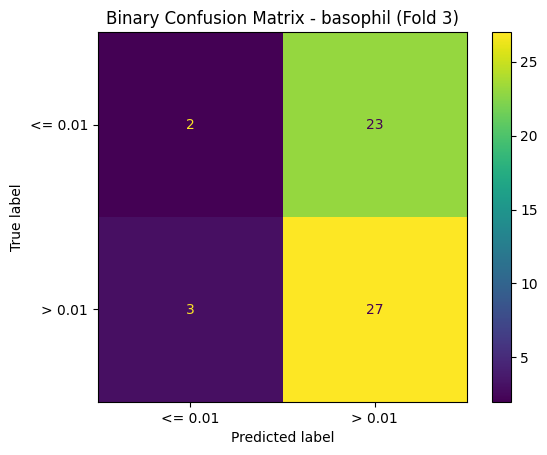

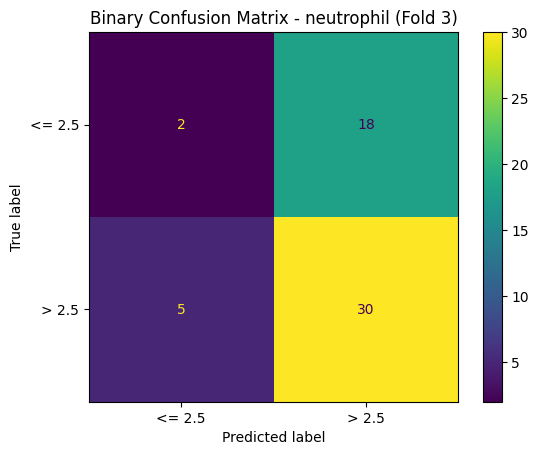

  Fold 3: Not enough class diversity for binary CM (RDW).
  Fold 3: Not enough class diversity for binary CM (RBC).
  Fold 3: Not enough class diversity for binary CM (platelet).
  Fold 3: Not enough class diversity for binary CM (monocyte).
  Fold 3: Not enough class diversity for binary CM (MCV).


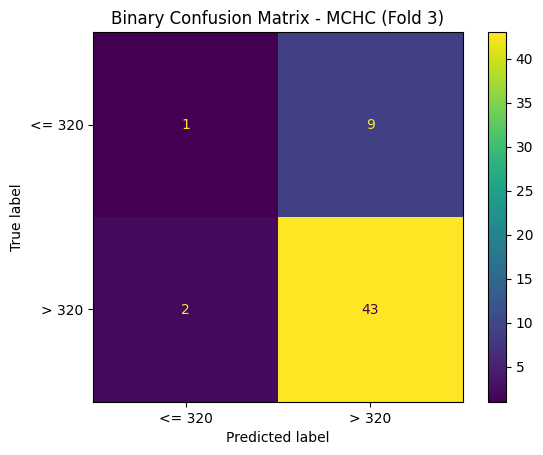

  Fold 3: Not enough class diversity for binary CM (lymphocyte).
  Fold 3: Not enough class diversity for binary CM (hemoglobin).
  Fold 3: Not enough class diversity for binary CM (hematocrit).
  Fold 3: Not enough class diversity for binary CM (eosinophil).
  Fold 3: Not enough class diversity for binary CM (WBC).
  Fold 3: Not enough class diversity for binary CM (MCH).

--- Starting Fold 4/5 ---
Fold 4: Train patients: 20 (183 images)
Fold 4: Val patients: 4 (40 images)
Fold 4: Test patients: 6 (55 images)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Fold 4...
[DEBUG] Total loss accumulated: 6.44430148601532
[DEBUG] Dataset size: 40
  Fold 4, Epoch 1/50 | Train Loss: 0.3414 | Val Loss: 0.1611 | Duration: 43.40s
[DEBUG] Total loss accumulated: 4.448635518550873
[DEBUG] Dataset size: 40
  Fold 4, Epoch 2/50 | Train Loss: 0.2193 | Val Loss: 0.1112 | Duration: 43.45s
[DEBUG] Total loss accumulated: 3.739390254020691
[DEBUG] Dataset size: 40
  Fold 4, Epoch 3/50 | Train Loss: 0.1751 | Val Loss: 0.0935 | Duration: 43.22s
[DEBUG] Total loss accumulated: 3.6185094118118286
[DEBUG] Dataset size: 40
  Fold 4, Epoch 4/50 | Train Loss: 0.1726 | Val Loss: 0.0905 | Duration: 43.14s
[DEBUG] Total loss accumulated: 3.642856776714325
[DEBUG] Dataset size: 40
  Fold 4, Epoch 5/50 | Train Loss: 0.1521 | Val Loss: 0.0911 | Duration: 43.29s
[DEBUG] Total loss accumulated: 3.628492534160614
[DEBUG] Dataset size: 40
  Fold 4, Epoch 6/50 | Train Loss: 0.1415 | Val Loss: 0.0907 | Duration: 42.84s
[DEBUG] Total loss accumulated: 3.614035189151764
[

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


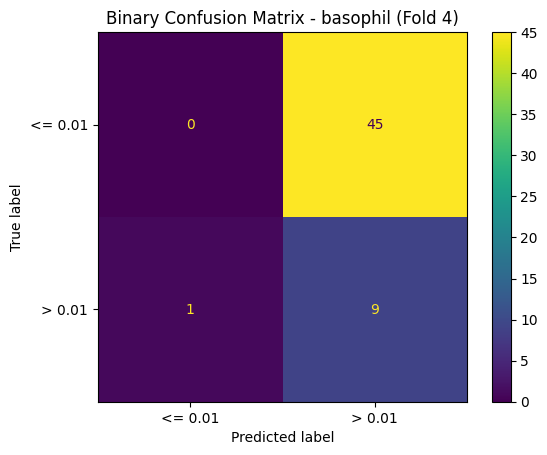

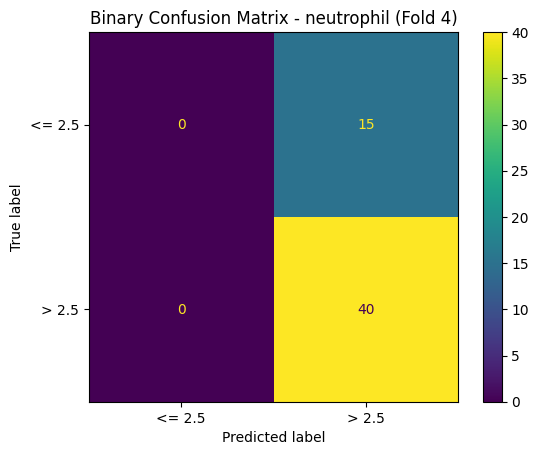

  Fold 4: Not enough class diversity for binary CM (RDW).


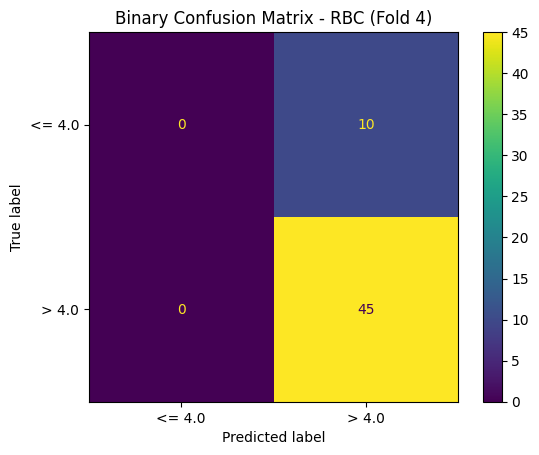

  Fold 4: Not enough class diversity for binary CM (platelet).
  Fold 4: Not enough class diversity for binary CM (monocyte).
  Fold 4: Not enough class diversity for binary CM (MCV).


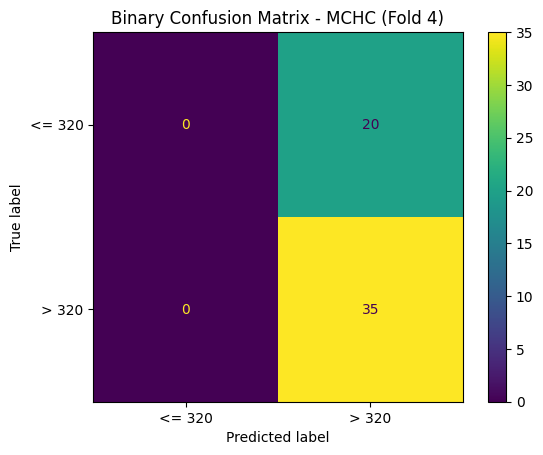

  Fold 4: Not enough class diversity for binary CM (lymphocyte).
  Fold 4: Not enough class diversity for binary CM (hemoglobin).
  Fold 4: Not enough class diversity for binary CM (hematocrit).


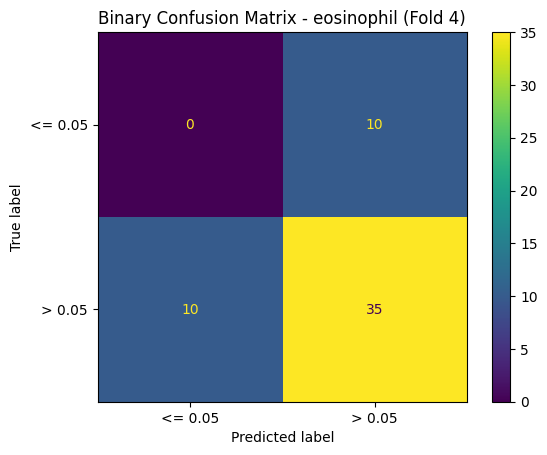

  Fold 4: Not enough class diversity for binary CM (WBC).
  Fold 4: Not enough class diversity for binary CM (MCH).

--- Starting Fold 5/5 ---
Fold 5: Train patients: 20 (185 images)
Fold 5: Val patients: 4 (40 images)
Fold 5: Test patients: 6 (53 images)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Fold 5...
[DEBUG] Total loss accumulated: 6.228042483329773
[DEBUG] Dataset size: 40
  Fold 5, Epoch 1/50 | Train Loss: 0.3313 | Val Loss: 0.1557 | Duration: 43.32s
[DEBUG] Total loss accumulated: 4.141290307044983
[DEBUG] Dataset size: 40
  Fold 5, Epoch 2/50 | Train Loss: 0.2105 | Val Loss: 0.1035 | Duration: 44.28s
[DEBUG] Total loss accumulated: 4.130675792694092
[DEBUG] Dataset size: 40
  Fold 5, Epoch 3/50 | Train Loss: 0.1601 | Val Loss: 0.1033 | Duration: 44.54s
[DEBUG] Total loss accumulated: 4.1391682624816895
[DEBUG] Dataset size: 40
  Fold 5, Epoch 4/50 | Train Loss: 0.1501 | Val Loss: 0.1035 | Duration: 44.47s
[DEBUG] Total loss accumulated: 3.7610800862312317
[DEBUG] Dataset size: 40
  Fold 5, Epoch 5/50 | Train Loss: 0.1423 | Val Loss: 0.0940 | Duration: 43.36s
[DEBUG] Total loss accumulated: 3.3595905900001526
[DEBUG] Dataset size: 40
  Fold 5, Epoch 6/50 | Train Loss: 0.1301 | Val Loss: 0.0840 | Duration: 43.67s
[DEBUG] Total loss accumulated: 3.20840466022491

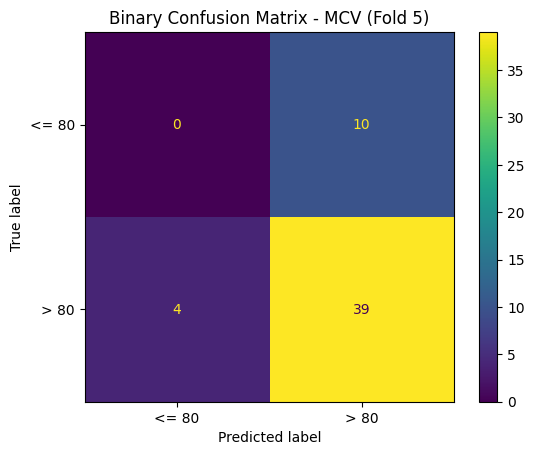

  Fold 5: Not enough class diversity for binary CM (MCHC).
  Fold 5: Not enough class diversity for binary CM (lymphocyte).
  Fold 5: Not enough class diversity for binary CM (hemoglobin).
  Fold 5: Not enough class diversity for binary CM (hematocrit).


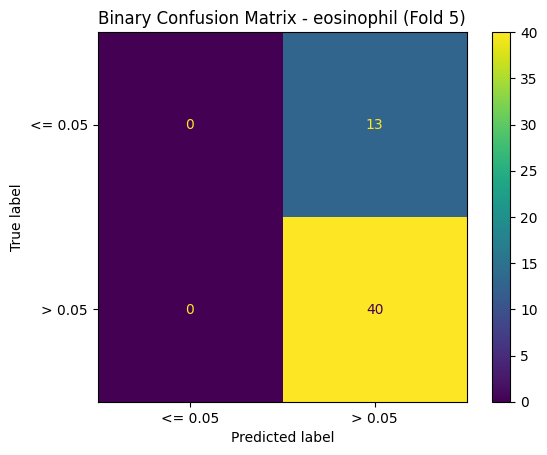

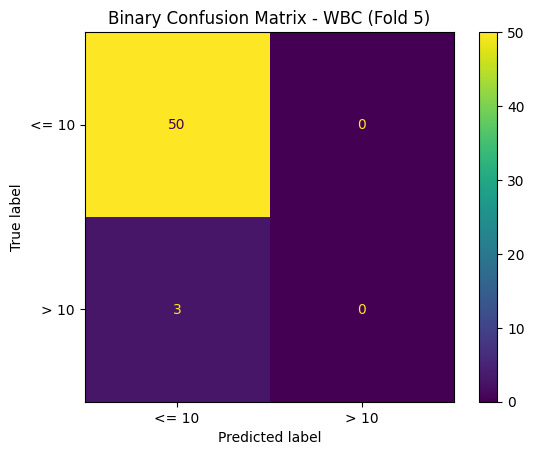

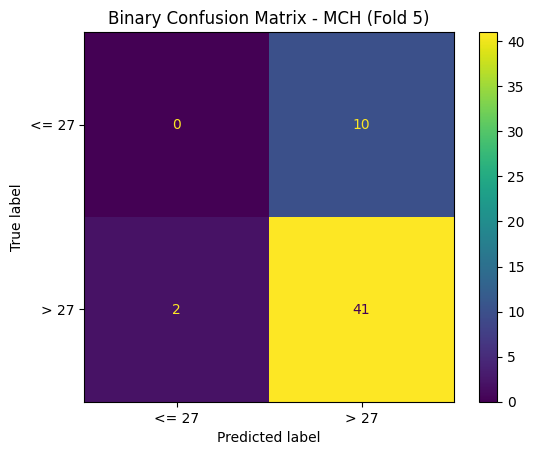


--- K-Fold Cross-Validation Complete ---

Average Test Loss across 5 folds: 0.0762
Average Macro AUC across 5 folds: 0.4844

Aggregated Binned Confusion Matrices:


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:
# --- K-Fold Training Loop ---
import numpy as np # Ensure numpy is imported if not already
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay # Import ConfusionMatrixDisplay for plotting
import matplotlib.pyplot as plt # Ensure matplotlib is imported if not already
import os # Ensure os is imported if not already
import torch # Ensure torch is imported if not already
from torch.utils.data import DataLoader # Ensure DataLoader is imported
from sklearn.model_selection import train_test_split # Ensure train_test_split is imported
import time # Import time for measuring epoch duration (optional but helpful)
from torch.optim.lr_scheduler import ReduceLROnPlateau # Import LR scheduler
from sklearn.preprocessing import QuantileTransformer # Import QuantileTransformer

print("Starting K-Fold Cross-Validation...")

# Ensure patience is defined (add this before the loop if not in a previous cell)
patience = 10  # Example patience value for early stopping

# Make sure label_min_tensor and label_max_tensor are accessible here
# They should be if defined in the "Clean Labels" section

# Ensure results directories exist (already done in Setup and Imports, but good to be aware)
os.makedirs(results_dir, exist_ok=True)

# Prepare lists and dictionaries to store metrics for each fold
fold_test_losses = []
fold_macro_aucs = [] # Initialize list for storing macro AUC per fold

# Use the selected_labels defined in the previous cell (which now includes all labels)
# selected_labels is already defined in the previous cell
# Get the index of the selected labels within the label_cols list
# Ensure label_cols is defined from the Clean Labels section
label_indices = [label_cols.index(lab) for lab in selected_labels]

# Initialize dictionaries to store confusion matrices lists for each selected label
# These were already initialized in the previous cell, but we'll keep the initialization structure
# here for clarity within this block if running it standalone.
fold_cms = {label: [] for label in selected_labels}
fold_binary_cms = {label: [] for label in selected_labels if label in binary_thresholds}


# Optional: Lists to store loss histories for plotting average curves (Moved from Train Loop Execution)
all_fold_train_losses = []
all_fold_val_losses = []


# Iterate through the folds
# gkf.split returns indices for train/test splits for each fold
for fold, (train_index, test_index) in enumerate(gkf.split(labels_df, groups=groups)):
    print(f"\n--- Starting Fold {fold+1}/{N_SPLITS} ---")

    # Get the dataframes for the current fold
    fold_train_df = labels_df.iloc[train_index].reset_index(drop=True)
    fold_test_df = labels_df.iloc[test_index].reset_index(drop=True)

    # Optional: Create a validation split *within* the training data for this fold
    # This is good practice for early stopping within each fold
    fold_train_ids = fold_train_df['patient_id'].unique()
    # Split train_ids into fold_train_ids_actual and fold_val_ids
    if len(fold_train_ids) > 1: # Ensure there's more than one patient to split
        fold_train_ids_actual, fold_val_ids = train_test_split(fold_train_ids, test_size=0.15, random_state=42) # e.g., 15% for validation
    else: # Handle cases with only one patient in the training fold (unlikely with GroupKFold on enough data)
        fold_train_ids_actual = fold_train_ids
        fold_val_ids = [] # No separate validation set if only one patient

    fold_train_df_actual = fold_train_df[fold_train_df['patient_id'].isin(fold_train_ids_actual)].reset_index(drop=True)
    fold_val_df = fold_train_df[fold_train_df['patient_id'].isin(fold_val_ids)].reset_index(drop=True)


    print(f"Fold {fold+1}: Train patients: {fold_train_df_actual['patient_id'].nunique()} ({len(fold_train_df_actual)} images)")
    print(f"Fold {fold+1}: Val patients: {fold_val_df['patient_id'].nunique()} ({len(fold_val_df)} images)")
    print(f"Fold {fold+1}: Test patients: {fold_test_df['patient_id'].nunique()} ({len(fold_test_df)} images)")

    # --- Apply Scaling to the current fold's splits ---
    # Recalculate min/max *from the training data of the current fold*
    # This is important for proper K-Fold evaluation
    fold_label_min = fold_train_df_actual[label_cols].min().values
    fold_label_max = fold_train_df_actual[label_cols].max().values

    # Store these for inverse scaling later in this fold's evaluation
    fold_label_min_tensor = torch.tensor(fold_label_min, dtype=torch.float32)
    fold_label_max_tensor = torch.tensor(fold_label_max, dtype=torch.float32)


    fold_train_df_scaled = scale_labels(fold_train_df_actual, label_cols, fold_label_min, fold_label_max)
    fold_val_df_scaled = scale_labels(fold_val_df, label_cols, fold_label_min, fold_label_max)
    fold_test_df_scaled = scale_labels(fold_test_df, label_cols, fold_label_min, fold_label_max)

    # --- Create DataLoaders for the current fold ---
    # Use the scaled dataframes for the current fold
    fold_train_loader = DataLoader(CBCDataset(fold_train_df_scaled, data_dir, transform=train_transform), batch_size=32, shuffle=True)
    fold_val_loader = DataLoader(CBCDataset(fold_val_df_scaled, data_dir, transform=val_test_transform), batch_size=32)
    fold_test_loader = DataLoader(CBCDataset(fold_test_df_scaled, data_dir, transform=val_test_transform), batch_size=32)


    # --- Model Setup (Re-initialize for each fold) ---
    model = get_resnet18_regression(n_labels)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # Added weight_decay
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True) # Initialized scheduler

    # --- Training Loop for the current fold ---
    best_fold_val_loss = float('inf')
    fold_epochs_no_improve = 0
    fold_train_losses, fold_val_losses = [], []
    FOLD_NUM_EPOCHS = 50 # Adjust based on how long you want to train each fold

    print(f"Training Fold {fold+1}...")

    for epoch in range(FOLD_NUM_EPOCHS):
        start_time = time.time() # Optional: Start time for epoch

        train_loss = train_one_epoch(model, fold_train_loader, optimizer, criterion)
        val_loss, _, _ = evaluate(model, fold_val_loader, criterion) # Evaluate on the fold's validation set

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)

        end_time = time.time() # Optional: End time for epoch
        epoch_duration = end_time - start_time # Optional: Calculate duration

        # Optional detailed print
        print(f"  Fold {fold+1}, Epoch {epoch+1}/{FOLD_NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Duration: {epoch_duration:.2f}s")


        # Early Stopping Check for the current fold
        if val_loss < best_fold_val_loss:
            best_fold_val_loss = val_loss
            fold_epochs_no_improve = 0
            # Optional: Save the best model for this fold
            torch.save(model.state_dict(), os.path.join(results_dir, f"best_model_fold_{fold+1}.pth"))
        else:
            fold_epochs_no_improve += 1
            if fold_epochs_no_improve == patience: # Use the patience from your original code
                print(f"  Early stopping triggered for Fold {fold+1}: Validation loss did not improve for {patience} epochs.")
                break # Stop training for this fold

        # Step the learning rate scheduler based on validation loss
        scheduler.step(val_loss) # Step the scheduler

    print(f"Finished Training Fold {fold+1}. Best Val Loss: {best_fold_val_loss:.4f}")

    # Optional: Store loss histories for plotting average curves
    all_fold_train_losses.append(fold_train_losses)
    all_fold_val_losses.append(fold_val_losses)


    # --- Evaluation on the Test Set of the current fold ---
    print(f"Evaluating Fold {fold+1} on test set...")
    test_loss, preds_scaled_np, targets_scaled_np = evaluate(model, fold_test_loader, criterion)

    # === Inverse Scale Predictions and Targets for evaluation metrics ===
    # Use the fold-specific min/max for inverse scaling
    preds_np = preds_scaled_np * (fold_label_max_tensor.numpy() - fold_label_min_tensor.numpy()) + fold_label_min_tensor.numpy()
    targets_np = targets_scaled_np * (fold_label_max_tensor.numpy() - fold_label_min_tensor.numpy()) + fold_label_min_tensor.numpy()

    # Store test loss for this fold
    fold_test_losses.append(test_loss)

    # === Calculate and store other metrics for this fold ===

    # Example for AUC (using a simple threshold on original scale):
    # You might want to define specific thresholds for each label if needed
    # This uses the midpoint of the fold's training data range as a threshold
    fold_threshold_original_auc = (fold_label_min_tensor.numpy() + fold_label_max_tensor.numpy()) / 2.0
    preds_bin_for_auc = (preds_np > fold_threshold_original_auc).astype(int)
    targets_bin_for_auc = (targets_np > fold_threshold_original_auc).astype(int)

    # Check if both classes are present before calculating AUC
    # This is crucial for roc_auc_score
    auc_calculable_indices_fold = []
    for i in range(len(label_cols)):
        # Check if the label is in selected_labels AND has both classes in true targets
        if label_cols[i] in selected_labels and len(np.unique(targets_bin_for_auc[:, i])) == 2:
             auc_calculable_indices_fold.append(i)

    if auc_calculable_indices_fold:
        try:
            # Calculate AUC only for labels with both classes and in selected_labels
            # Need to select only the columns for auc_calculable_indices_fold
            fold_auc = roc_auc_score(targets_bin_for_auc[:, auc_calculable_indices_fold], preds_np[:, auc_calculable_indices_fold], average='macro')
            fold_macro_aucs.append(fold_auc)
        except ValueError as e:
            print(f"  Fold {fold+1}: Error calculating AUC - {e}")
            fold_macro_aucs.append(np.nan) # Append NaN if AUC calculation fails
    else:
        print(f"  Fold {fold+1}: Not enough class diversity or labels not in selected_labels for AUC calculation.")
        fold_macro_aucs.append(np.nan) # Append NaN if AUC cannot be calculated


    # --- Calculate Dynamic Bin Edges for the test set of this fold ---
    # Initialize a dictionary to store dynamic bin edges for the current fold
    fold_dynamic_bin_edges = {}
    n_bins_for_cm = 5 # Define the number of bins for confusion matrices (you can adjust this)

    for i, label in zip(label_indices, selected_labels):
        target_values = targets_np[:, i].reshape(-1, 1) # Extract true values for this label and reshape

        # Ensure there's enough data and unique values for quantile binning
        if len(target_values) > 0 and len(np.unique(target_values)) > 1:
            try:
                qt = QuantileTransformer(n_quantiles=n_bins_for_cm, output_distribution='uniform', random_state=42)
                qt.fit(target_values)
                # Add the min and max to the quantile edges to cover the full range
                dynamic_bins = [target_values.min()] + qt.quantiles_.flatten().tolist() + [target_values.max()]
                # Ensure bins are unique and sorted (sometimes quantiles can be the same)
                dynamic_bins = sorted(list(set(dynamic_bins)))
                fold_dynamic_bin_edges[label] = dynamic_bins
            except ValueError as e:
                 print(f"  Fold {fold+1}: Could not calculate quantile bins for label '{label}'. Error: {e}")
                 # Fallback to static bins if defined, otherwise an empty list
                 fold_dynamic_bin_edges[label] = bin_edges.get(label, [])
        else:
             print(f"  Fold {fold+1}: Not enough data or unique values for quantile binning for label '{label}'. Skipping dynamic binning.")
             # Fallback to static bins if defined, otherwise an empty list
             fold_dynamic_bin_edges[label] = bin_edges.get(label, [])


    # --- Calculate and store Binned Confusion Matrices for selected labels (using dynamic bins) ---
    for i, label in zip(label_indices, selected_labels):
        # Use the dynamic bin edges calculated for this fold and label
        if label in fold_dynamic_bin_edges and fold_dynamic_bin_edges[label]: # Check if dynamic bins were calculated and are not empty
            bins = fold_dynamic_bin_edges[label] # Use dynamic bins
            # Ensure there are at least two bin edges to form a bin
            if len(bins) > 1:
                y_true_binned = np.digitize(targets_np[:, i], bins) - 1
                y_pred_binned = np.digitize(preds_np[:, i], bins) - 1
                # Determine the possible range of binned labels based on the dynamic bins
                # The maximum possible bin index is len(bins) - 2
                valid_labels = range(len(bins) - 1) # Bin indices from 0 to n_bins-1

                if len(y_true_binned) > 0:
                     # Calculate confusion matrix with all possible bin labels (0 to n_bins-1)
                     # This ensures a consistent dimension for aggregation, even if some bins are empty in this fold
                     all_possible_bin_labels = range(n_bins_for_cm) # Use the intended number of bins
                     cm = confusion_matrix(y_true_binned, y_pred_binned, labels=list(all_possible_bin_labels))

                     # Pad the confusion matrix to a consistent size (n_bins_for_cm x n_bins_for_cm)
                     # Although the CM is calculated with all possible labels, explicitly ensuring padding
                     # for robustness in case of unexpected edge cases.
                     target_shape = (n_bins_for_cm, n_bins_for_cm)
                     padded_cm = np.zeros(target_shape, dtype=int)
                     rows, cols = cm.shape
                     padded_cm[:rows, :cols] = cm[:target_shape[0], :target_shape[1]]


                     fold_cms[label].append(padded_cm) # Store the padded CM for this label in this fold
                else:
                     print(f"  Fold {fold+1}: No test data for label '{label}'. Cannot calculate binned CM.")


            else:
                print(f"  Fold {fold+1}: Dynamic binning failed or resulted in insufficient bins for label '{label}'. Skipping binned CM.")

        else:
            print(f"  Fold {fold+1}: No dynamic or static bin edges defined for label '{label}'. Skipping binned CM.")


    # --- Calculate and store Binary Confusion Matrices for selected labels ---
    for i, label in zip(label_indices, selected_labels):
        if label in binary_thresholds:
            threshold = binary_thresholds[label]
            y_true_binary = (targets_np[:, i] > threshold).astype(int)
            y_pred_binary = (preds_np[:, i] > threshold).astype(int)

            # Check if both classes (0 and 1) are present in the true labels for this fold's test set
            if len(np.unique(y_true_binary)) == 2:
                cm_binary = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])

                # Store binary confusion matrices for aggregation later
                fold_binary_cms[label].append(cm_binary) # Store the binary CM for this label in this fold

                # Optional: Display the binary confusion matrix for this fold
                disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=[f'<= {threshold}', f'> {threshold}'])
                disp.plot()
                plt.title(f'Binary Confusion Matrix - {label} (Fold {fold+1})')
                plt.show()
            else:
                 print(f"  Fold {fold+1}: Not enough class diversity for binary CM ({label}).")
        else:
            print(f"  Fold {fold+1}: No binary threshold defined for label '{label}'. Skipping binary CM.")


# --- Aggregate Results After All Folds ---
print("\n--- K-Fold Cross-Validation Complete ---")

print(f"\nAverage Test Loss across {N_SPLITS} folds: {np.mean(fold_test_losses):.4f}")

# Print average of other stored metrics
if fold_macro_aucs and not np.all(np.isnan(fold_macro_aucs)):
   print(f"Average Macro AUC across {len(fold_macro_aucs)} folds: {np.nanmean(fold_macro_aucs):.4f}")
else:
    print("\nCould not calculate average Macro AUC (no valid AUC values were computed across folds).")


# --- Aggregate and Display Binned Confusion Matrices ---
if fold_cms:
   print("\nAggregated Binned Confusion Matrices:")
   for label in selected_labels:
       if label in fold_cms and fold_cms[label]: # Check if any CMs were stored for this label
            # Ensure all confusion matrices for this label have the same dimensions before summing
            # Find the maximum dimensions across all CMs for this label
            max_dim = 0
            for cm in fold_cms[label]:
                 max_dim = max(max_dim, cm.shape[0]) # Assuming square matrices

            # Pad smaller matrices if necessary (though dynamic binning with fixed n_bins should help)
            # This padding logic might need refinement depending on how dynamic binning behaves
            # A simpler approach is to ensure the confusion_matrix call uses labels covering the max possible bin index

            aggregated_cm = np.sum(fold_cms[label], axis=0)
            print(f"\nAggregated Binned Confusion Matrix - {label}:")
            print(aggregated_cm)
            # Optional: Display the aggregated confusion matrix visually
            # Ensure you have bin_edges defined (using static for display or recalculating average dynamic)
            # For aggregated CM, using the static bin_edges or calculating average dynamic bins for labels
            if label in bin_edges: # Fallback to static for display
                bins = bin_edges[label]
                # Need to ensure display labels match the aggregated CM dimensions
                # The aggregated CM has dimensions based on the maximum number of bins encountered
                # For display, we can try to generate labels based on the aggregated matrix dimensions
                agg_dim = aggregated_cm.shape[0]
                if agg_dim > 0:
                    display_labels = [f'Bin {i}' for i in range(agg_dim)] # Generic labels if static mismatch
                    # Or try to map back to ranges if using static bins
                    if len(bins) - 1 == agg_dim: # If static bins match aggregated dimensions
                         display_labels = [f'{bins[k]:.2f}-{bins[k+1]:.2f}' for k in range(len(bins)-1)]

                    disp = ConfusionMatrixDisplay(confusion_matrix=aggregated_cm, display_labels=display_labels)
                    disp.plot()
                    plt.title(f'Aggregated Binned Confusion Matrix - {label}')
                    plt.show()
                else:
                     print(f"  Aggregated CM for '{label}' is empty. Cannot plot.")

            else:
                print(f"  Cannot plot binned CM for '{label}': static bin_edges not defined or mismatch with aggregated dimensions.")
       elif label in selected_labels: # If label is selected but no binned CMs were stored
           print(f"\nNo binned confusion matrices were aggregated for label '{label}'.")


# --- Aggregate and Display Binary Confusion Matrices ---
# Ensure binary_thresholds and selected_labels are accessible
if fold_binary_cms:
   print("\nAggregated Binary Confusion Matrices:")
   for label in selected_labels:
       if label in fold_binary_cms and fold_binary_cms[label]: # Check if any binary CMs were stored for this label
            aggregated_binary_cm = np.sum(fold_binary_cms[label], axis=0)
            print(f"\nAggregated Binary Confusion Matrix - {label}:")
            print(aggregated_binary_cm)
            # Optional: Display the aggregated binary confusion matrix visually
            # Use the threshold value in the display labels
            if label in binary_thresholds:
                threshold = binary_thresholds.get(label, 'N/A') # Get threshold or 'N/A' if not found
                disp = ConfusionMatrixDisplay(confusion_matrix=aggregated_binary_cm, display_labels=[f'<= {threshold}', f'> {threshold}'])
                disp.plot()
                plt.title(f'Aggregated Binary Confusion Matrix - {label}')
                plt.show()
            else:
                 print(f"  Cannot plot binary CM for '{label}': binary_threshold not defined.")
       elif label in selected_labels: # If label is selected but no binary CMs were stored
           print(f"\nNo binary confusion matrices were aggregated for label '{label}'.")


# --- Plot Loss Curves (Example: Plotting last fold or average) ---
# Plotting loss curves per fold or averaged requires storing fold_train_losses and fold_val_losses per fold.
# If you stored them in all_fold_train_losses and all_fold_val_losses:
if 'all_fold_train_losses' in locals() and 'all_fold_val_losses' in locals() and all_fold_train_losses:
   max_epochs = max(len(losses) for losses in all_fold_train_losses)
   padded_train_losses = np.array([losses + [np.nan] * (max_epochs - len(losses)) for losses in all_fold_train_losses])
   padded_val_losses = np.array([losses + [np.nan] * (max_epochs - len(losses)) for losses in all_fold_val_losses])
   average_train_losses = np.nanmean(padded_train_losses, axis=0)
   average_val_losses = np.nanmean(padded_val_losses, axis=0)
   plt.plot(average_train_losses, label="Average Train")
   plt.plot(average_val_losses, label="Average Validation")
   plt.title("Average Loss Curve (K-Fold CV)")
   plt.xlabel("Epoch")
   plt.ylabel("Loss")
   plt.legend()
   plt.savefig(os.path.join(results_dir, "average_kfold_loss_curve.png"))
   plt.show()
# else: # Plot the last fold's curves if available
if 'fold_train_losses' in locals() and 'fold_val_losses' in locals() and fold_train_losses:
    plt.plot(fold_train_losses, label="Train (Last Fold)")
    plt.plot(fold_val_losses, label="Validation (Last Fold)")
    plt.title(f"Loss Curve (Last Fold of {N_SPLITS}-Fold CV)") # Corrected N_SPLBITS to N_SPLITS
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(results_dir, "last_fold_loss_curve.png"))
    plt.show()
else:
    print("\nLoss histories not available for plotting.")


# --- Save model (Optional: save the model from the last fold or the one with best average perf) ---
# You might want to save the model state_dict from the fold that had the best test performance
# or the last trained model, depending on your goal.
torch.save(model.state_dict(), os.path.join(results_dir, "final_kfold_model.pth")) # This would save the model from the last fold

# --- Save Loss Histories and Metrics ---
# Saving the test losses and macro AUCs across folds
np.save(os.path.join(results_dir, "kfold_test_losses.npy"), np.array(fold_test_losses))
if fold_macro_aucs:
    np.save(os.path.join(results_dir, "kfold_macro_aucs.npy"), np.array(fold_macro_aucs)) # Save AUCs if they were computed
# If you stored confusion matrices
if fold_cms:
   # Saving a dictionary with numpy arrays as values can be done with allow_pickle=True
   np.save(os.path.join(results_dir, "kfold_binned_cms.npy"), fold_cms, allow_pickle=True)
if fold_binary_cms:
   # Saving a dictionary with numpy arrays as values can be done with allow_pickle=True
   np.save(os.path.join(results_dir, "kfold_binary_cms.npy"), fold_binary_cms, allow_pickle=True)

# **Evaluation and Save**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Load or access stored K-Fold metrics ---
# These variables should be available from the previous cell if you ran it
# Example:
# fold_test_losses
# fold_macro_aucs
# fold_cms # If you stored confusion matrices

print("\n--- Aggregated K-Fold Results ---")

# --- Aggregate and Print Test Loss ---
if fold_test_losses:
    avg_test_loss = np.mean(fold_test_losses)
    std_test_loss = np.std(fold_test_losses)
    print(f"\nAverage Test Loss across {N_SPLITS} folds: {avg_test_loss:.4f} +/- {std_test_loss:.4f}")

# --- Aggregate and Print Macro AUC ---
if fold_macro_aucs and not np.all(np.isnan(fold_macro_aucs)):
    avg_macro_auc = np.nanmean(fold_macro_aucs) # Use nanmean to handle NaNs if AUC wasn't calculable for some folds
    std_macro_auc = np.nanstd(fold_macro_aucs) # Use nanstd
    print(f"Average Macro AUC across {N_SPLITS} folds: {avg_macro_auc:.4f} +/- {std_macro_auc:.4f}")
else:
    print("\nCould not calculate average Macro AUC (no valid AUC values were computed across folds).")


# --- Aggregate and Display Confusion Matrices ---
# Ensure bin_edges, selected_labels, label_cols are available from previous cells
if fold_cms:
   print("\nAggregated Confusion Matrices:")
   for label in selected_labels:
       if fold_cms[label]: # Check if any CMs were stored for this label
            aggregated_cm = np.sum(fold_cms[label], axis=0)
            print(f"\nAggregated Confusion Matrix - {label}:")
            print(aggregated_cm)
            # Optional: Display the aggregated confusion matrix visually
            # Ensure you have bin_edges defined
            bins = bin_edges[label]
            all_possible_binned_labels = range(len(bins) - 1)
            disp = ConfusionMatrixDisplay(confusion_matrix=aggregated_cm, display_labels=[f'{bins[k]}-{bins[k+1]}' for k in all_possible_binned_labels])
            disp.plot()
            plt.title(f'Aggregated Binned Confusion Matrix - {label}')
            plt.show()


# --- Plot Loss Curves (Example: Plotting last fold or average) ---
# If you stored loss histories per fold (all_fold_train_losses, all_fold_val_losses)
# you can calculate and plot the average curves here as discussed in the previous answer.
# Or plot the last fold's curves if fold_train_losses and fold_val_losses are available from the last fold.
# Example (Last Fold):
if 'fold_train_losses' in locals() and 'fold_val_losses' in locals():
    plt.plot(fold_train_losses, label="Train (Last Fold)")
    plt.plot(fold_val_losses, label="Validation (Last Fold)")
    plt.title("Loss Curve (Last Fold)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(results_dir, "last_fold_loss_curve.png"))
    plt.show()


# --- Save Aggregated Results ---
np.save(os.path.join(results_dir, "kfold_test_losses.npy"), np.array(fold_test_losses))
if fold_macro_aucs:
    np.save(os.path.join(results_dir, "kfold_macro_aucs.npy"), np.array(fold_macro_aucs))
# If you stored confusion matrices
if fold_cms:
    np.save(os.path.join(results_dir, "kfold_cms.npy"), fold_cms) # Saving a dictionary might need more thought, consider saving per label or a structured format.


# --- Save Final Model (Optional) ---
# Decide if you want to save a model from the K-Fold process.
# For example, save the model from the fold with the best test performance
# or the model trained on the full dataset after K-Fold (requires separate training).
torch.save(model.state_dict(), os.path.join(results_dir, "final_kfold_model.pth")) # This would save the model from the last fold


--- Aggregated K-Fold Results ---

Average Test Loss across 5 folds: 0.0762 +/- 0.0095
Average Macro AUC across 5 folds: 0.4844 +/- 0.0560

Aggregated Confusion Matrices:


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.